# Infant Mortality Indicator
- **Project: Analysis of the dynamics of COVID-19 infection in Colombia**
- **Analysis: Time Series**
- **Data: SIVIGILA - Weekly infant mortality ratio in Colombia [2017-2020]**
- **Created by: Andrés Segura Tinoco**
- **Created on: July 15, 2020**

In [1]:
# Import Python libraries
import pandas as pd
import numpy as np
import itertools
import timeit
from scipy import stats
from math import pi, sqrt, ceil
from warnings import catch_warnings
from warnings import filterwarnings

In [2]:
# Import Parallel libraries
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed

In [3]:
# Import Time Series libraries
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [4]:
# Import Plot libraries
import matplotlib.pyplot as plt
import seaborn as sns

## Index
1. Visual Analytics
2. Base Line
3. Time Series Analysis
4. Box-Jenkins Analysis
5. Holt-Winters Analysis
6. Compare Models

#### Load full data

In [5]:
# Read raw data
data_url = "../data/im_weekly_data.csv"
rawdata = pd.read_csv(data_url, parse_dates=["date"], index_col=["date"])
rawdata

,year,month,month_name,value
date,,,,
2017-01-01,2017,1,January,201
2017-01-08,2017,1,January,193
2017-01-15,2017,1,January,193
2017-01-22,2017,1,January,213
2017-01-29,2017,1,January,227
...,...,...,...,...
2020-01-19,2020,1,January,144
2020-01-26,2020,1,January,152
2020-02-02,2020,2,February,153


## 1. Visual Analytics

### 1.1. Plot full data

In [6]:
# Create pretty x axis labels
def get_x_labels(all_labels):
    x_labels = []
    for ix in range(len(all_labels)):
        if ix % 5 == 0:
            date_label = str(all_labels[ix]).replace('T', '*').split('*')[0]
            x_labels.append(date_label)
        else:
            x_labels.append('')
    return x_labels

In [7]:
# Cooking weekly data
x_date = np.array(rawdata.index)
x_data = np.array(range(len(x_date))).reshape((-1, 1))
y_data = np.array(rawdata.value)
xticks = get_x_labels(x_date)
max_y = int(max(y_data) * 1.1)

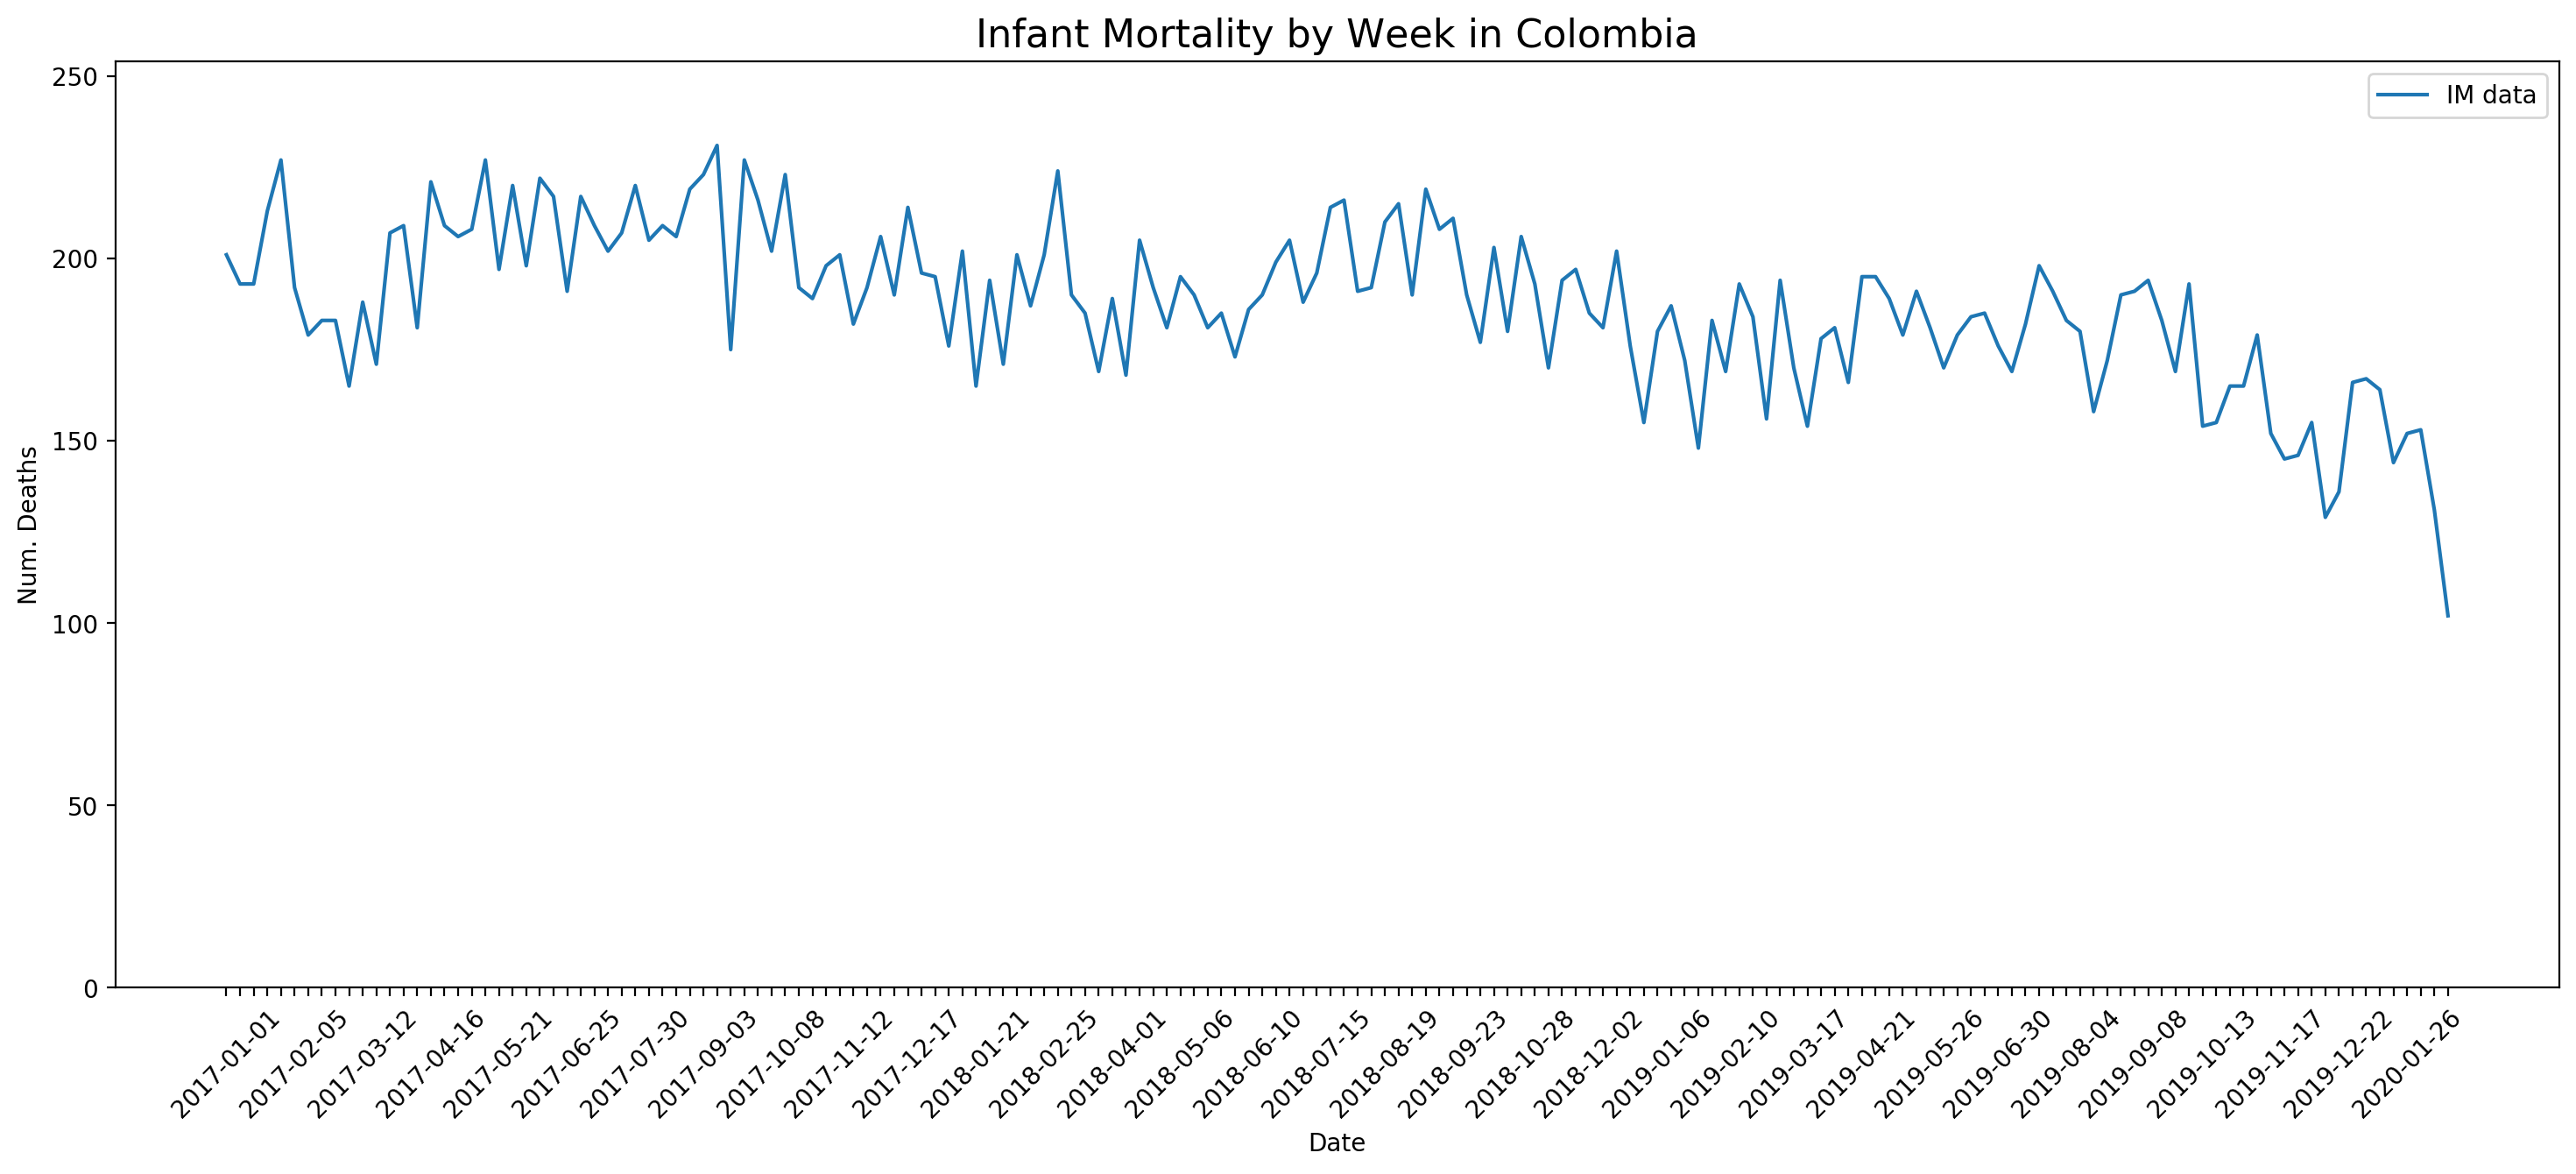

In [8]:
# Plot raw data
plt.figure(figsize=(18, 7), dpi=200)
plt.plot(x_data, y_data, label='IM data')
plt.ylim((0, max_y))
plt.title('Infant Mortality by Week in Colombia', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.xticks(x_data, xticks, rotation=45)
plt.legend()
plt.show()

### 1.2. Data by year

In [9]:
# Grouping data by year
dt = rawdata.groupby(['year']).agg('sum')
dt['diff'] = dt['value'].diff()
dt[['value', 'diff']]

,value,diff
year,,
2017,10747,NaN
2018,9963,-784.0
2019,9039,-924.0
2020,1013,-8026.0


In [10]:
# Grouping data by January and February
dt = rawdata[rawdata['month'].isin([1, 2])].groupby(['year']).agg('sum')
dt['diff'] = dt['value'].diff()
dt[['value', 'diff']]

,value,diff
year,,
2017,1764,NaN
2018,1497,-267.0
2019,1416,-81.0
2020,1013,-403.0


In [11]:
# Cooking data for year 2017
data_2017 = rawdata[rawdata['year'] == 2017]['value']
print('2017 Records: %s' % len(data_2017))
print('Total cases: %s' % sum(data_2017))
print('Average cases: %.2f' % np.mean(data_2017))
print('Median cases: %.2f' % np.median(data_2017))
print('Standard deviation: %.2f' % np.std(data_2017))

2017 Records: 53
Total cases: 10747
Average cases: 202.77
Median cases: 205.00
Standard deviation: 15.60


In [12]:
# Cooking data for year 2018
data_2018 = rawdata[rawdata['year'] == 2018]['value']
print('2018 Records: %s' % len(data_2018))
print('Total cases: %s' % sum(data_2018))
print('Average cases: %.2f' % np.mean(data_2018))
print('Median cases: %.2f' % np.median(data_2018))
print('Standard deviation: %.2f' % np.std(data_2018))

2018 Records: 52
Total cases: 9963
Average cases: 191.60
Median cases: 190.50
Standard deviation: 14.80


In [13]:
# Cooking data for year 2019
data_2019 = rawdata[rawdata['year'] == 2019]['value']
print('2019 Records: %s' % len(data_2019))
print('Total cases: %s' % sum(data_2019))
print('Average cases: %.2f' % np.mean(data_2019))
print('Median cases: %.2f' % np.median(data_2019))
print('Standard deviation: %.2f' % np.std(data_2019))

2019 Records: 52
Total cases: 9039
Average cases: 173.83
Median cases: 179.00
Standard deviation: 16.50


In [14]:
# Cooking data for year 2020
data_2020 = rawdata[rawdata['year'] == 2020]['value']
print('2020 Records: %s' % len(data_2020))
print('Total cases: %s' % sum(data_2020))
print('Average cases: %.2f' % np.mean(data_2020))
print('Median cases: %.2f' % np.median(data_2020))
print('Standard deviation: %.2f' % np.std(data_2020))

2020 Records: 7
Total cases: 1013
Average cases: 144.71
Median cases: 152.00
Standard deviation: 20.71


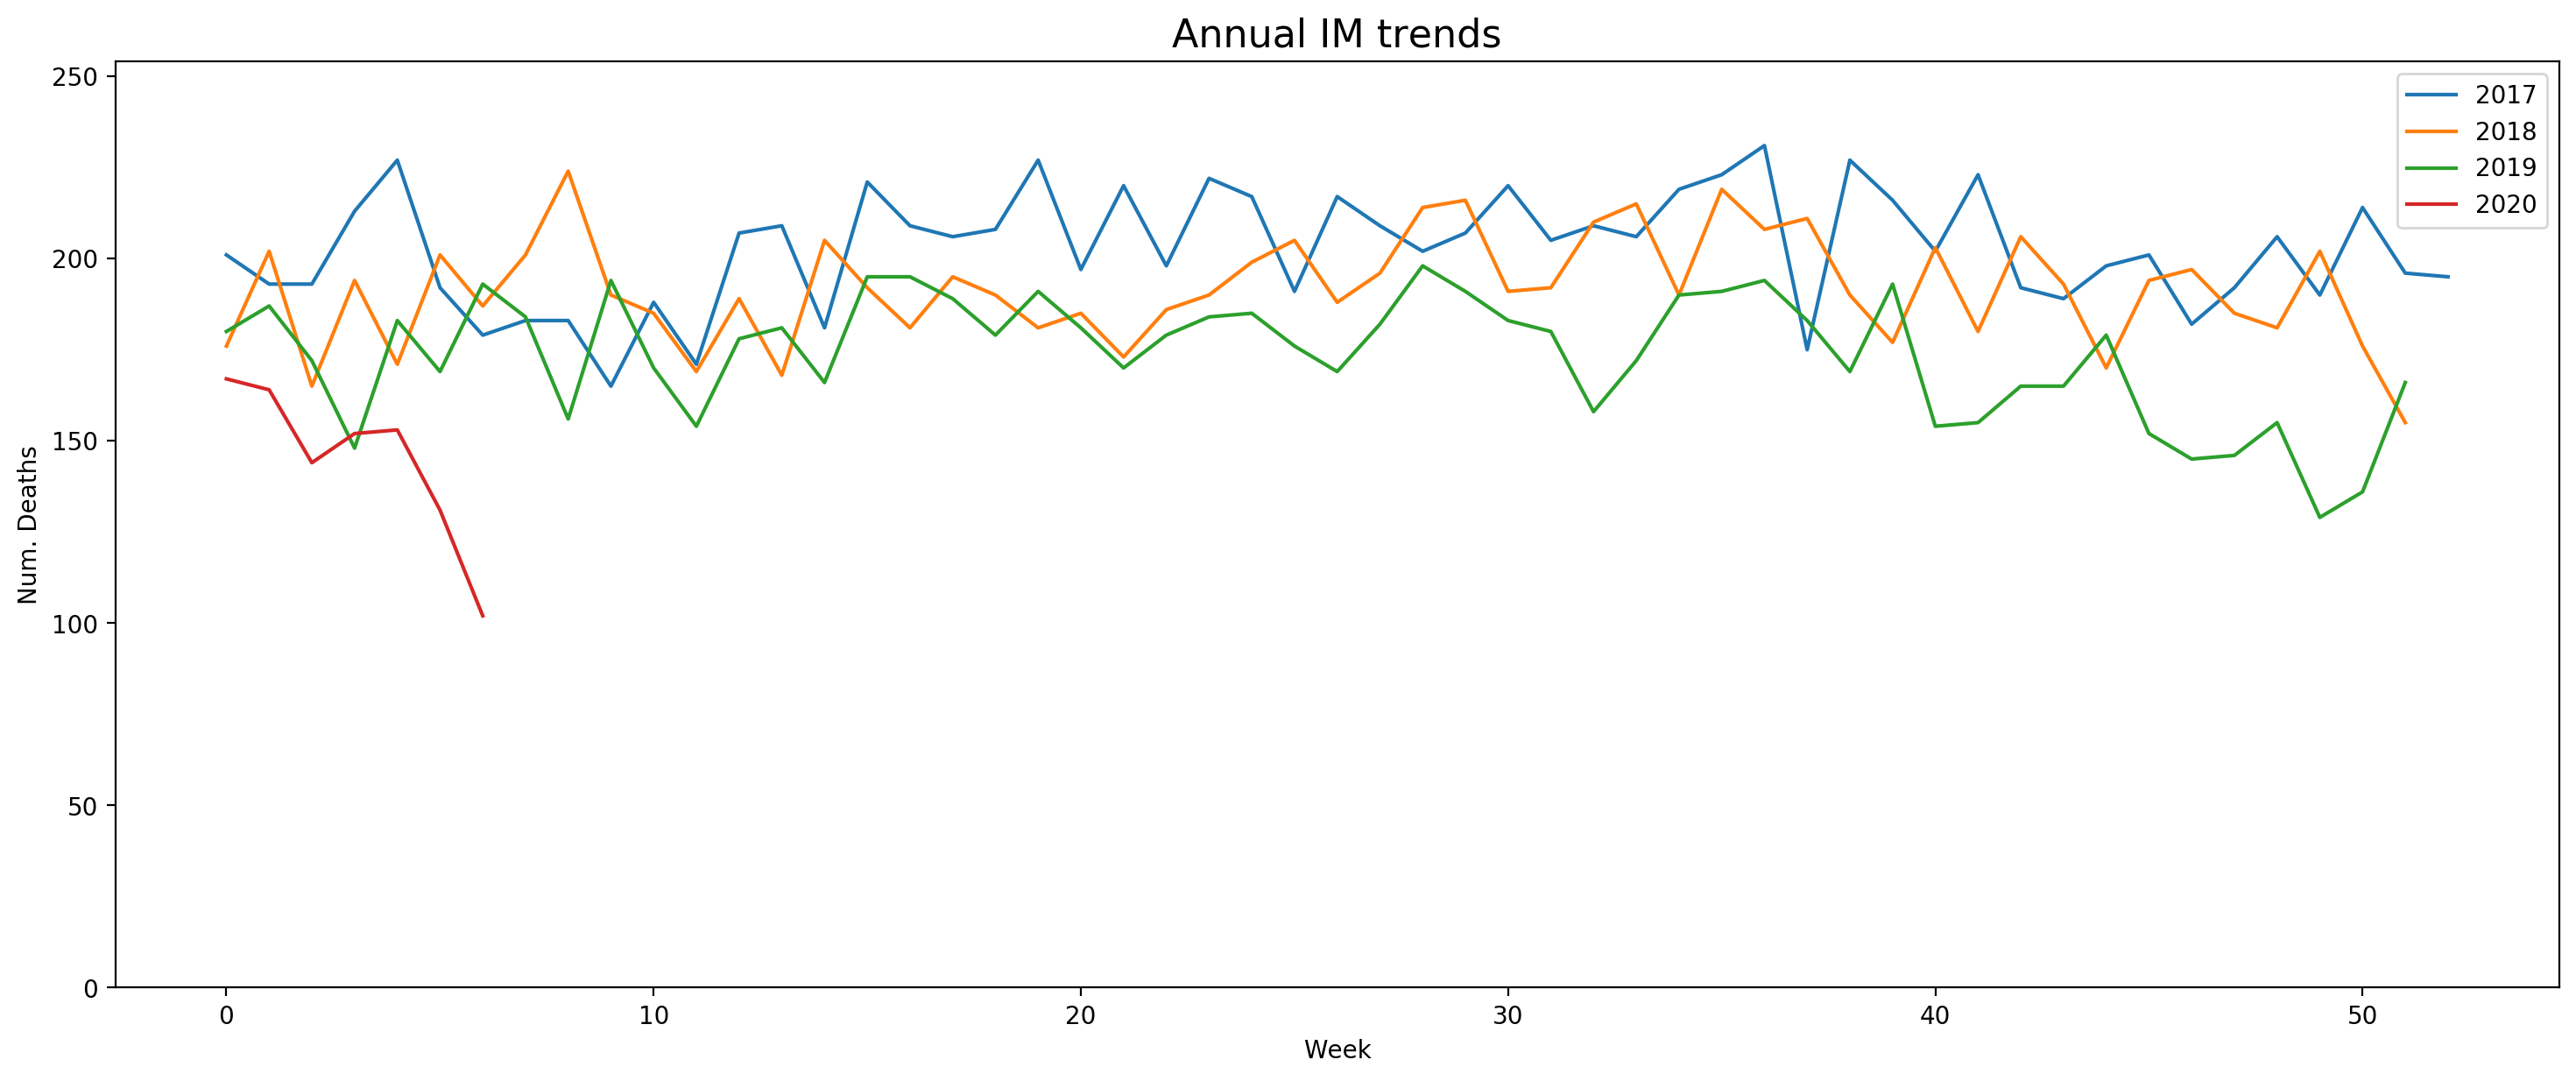

In [15]:
# Plot trends by year
plt.figure(figsize=(18, 7), dpi=200)
plt.plot(range(len(data_2017)), data_2017, label='2017')
plt.plot(range(len(data_2018)), data_2018, label='2018')
plt.plot(range(len(data_2019)), data_2019, label='2019')
plt.plot(range(len(data_2020)), data_2020, label='2020')
plt.ylim((0, max_y))
plt.title('Annual IM trends', fontsize=16)
plt.xlabel('Week', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.xticks(fontsize=10)
plt.legend()
plt.show()

### 1.3. Check Month-wise (seasonal) and Year-wise (trend) distribution

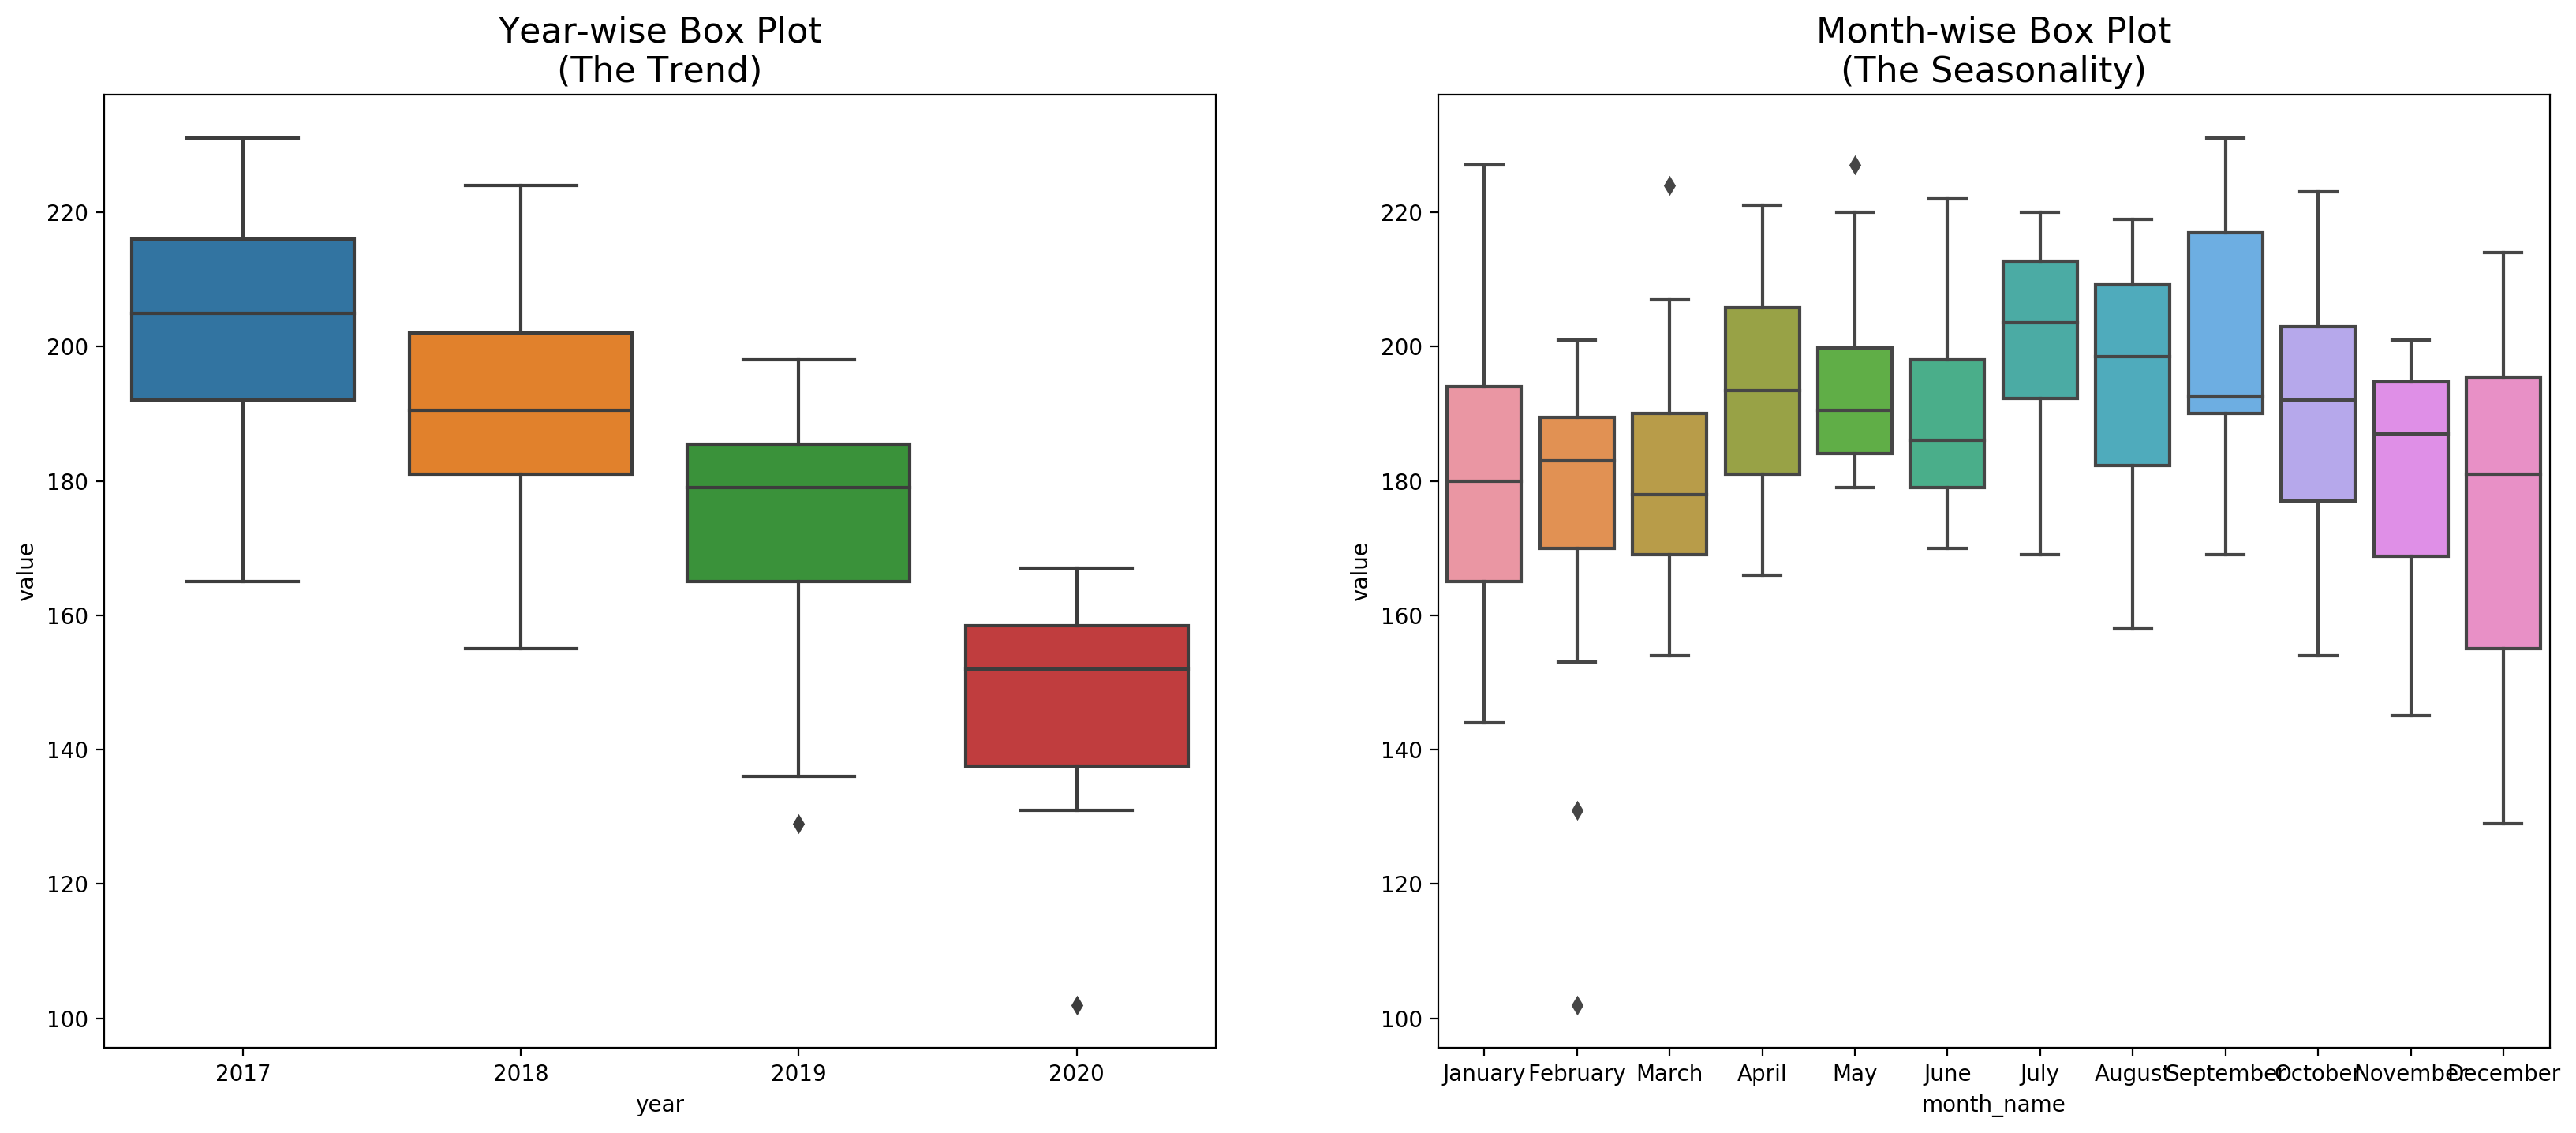

In [16]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi= 200)
sns.boxplot(x='year', y='value', data=rawdata, ax=axes[0])
sns.boxplot(x='month_name', y='value', data=rawdata, ax=axes[1])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=16); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=16)
plt.show()

#### Result
The dataset contains an obvious trend but no obvious seasonal component.

## 2. Base Line

The error validation functions are defined:

In [17]:
# Calculate root mean squared error or RMSE
def calc_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [18]:
# Calculate mean absolute percentage error or MAPE
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def calc_mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [19]:
# Calculate confidence interval
def get_interval(y, y_pred, pi=0.99):
    n = len(y)
    
    # Get standard deviation of y_test
    sum_errs = np.sum((y - y_pred)**2) / (n - 2)
    stdev = np.sqrt(sum_errs)
    
    # Get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    return interval

### 2.1. Linear Regression

In [20]:
# Create model LR
degree = 4
x_ = PolynomialFeatures(degree=degree, include_bias=True).fit_transform(x_data)
model = LinearRegression().fit(x_, y_data)

# Validate model
r_sq = model.score(x_, y_data)
print('Correlation:', sqrt(r_sq))
print('Coefficient of determination:', r_sq)
print('Intercept:', model.intercept_, ', Slope:', model.coef_)

Correlation: 0.7260526381805937
Coefficient of determination: 0.5271524334090001
Intercept: 189.34299451495244 , Slope: [ 0.00000000e+00  1.52452942e+00 -4.37806828e-02  4.15763538e-04
 -1.33347333e-06]


In [21]:
# Prediction
y_pred = model.predict(x_)

# Calculate errors
rmse = calc_rmse(y_data, y_pred)
mape = calc_mape(y_data, y_pred)
print('The RMSE of our forecasts is: {}'.format(round(rmse, 3)))
print('The MAPE of our forecasts is: {} %'.format(round(mape, 3)))

The RMSE of our forecasts is: 14.92
The MAPE of our forecasts is: 6.529 %


In [22]:
ci_alpha = 0.9
ci = get_interval(y_data, y_pred, ci_alpha)
print('Conf. Int.:', ci)

Conf. Int.: 24.692955439053193


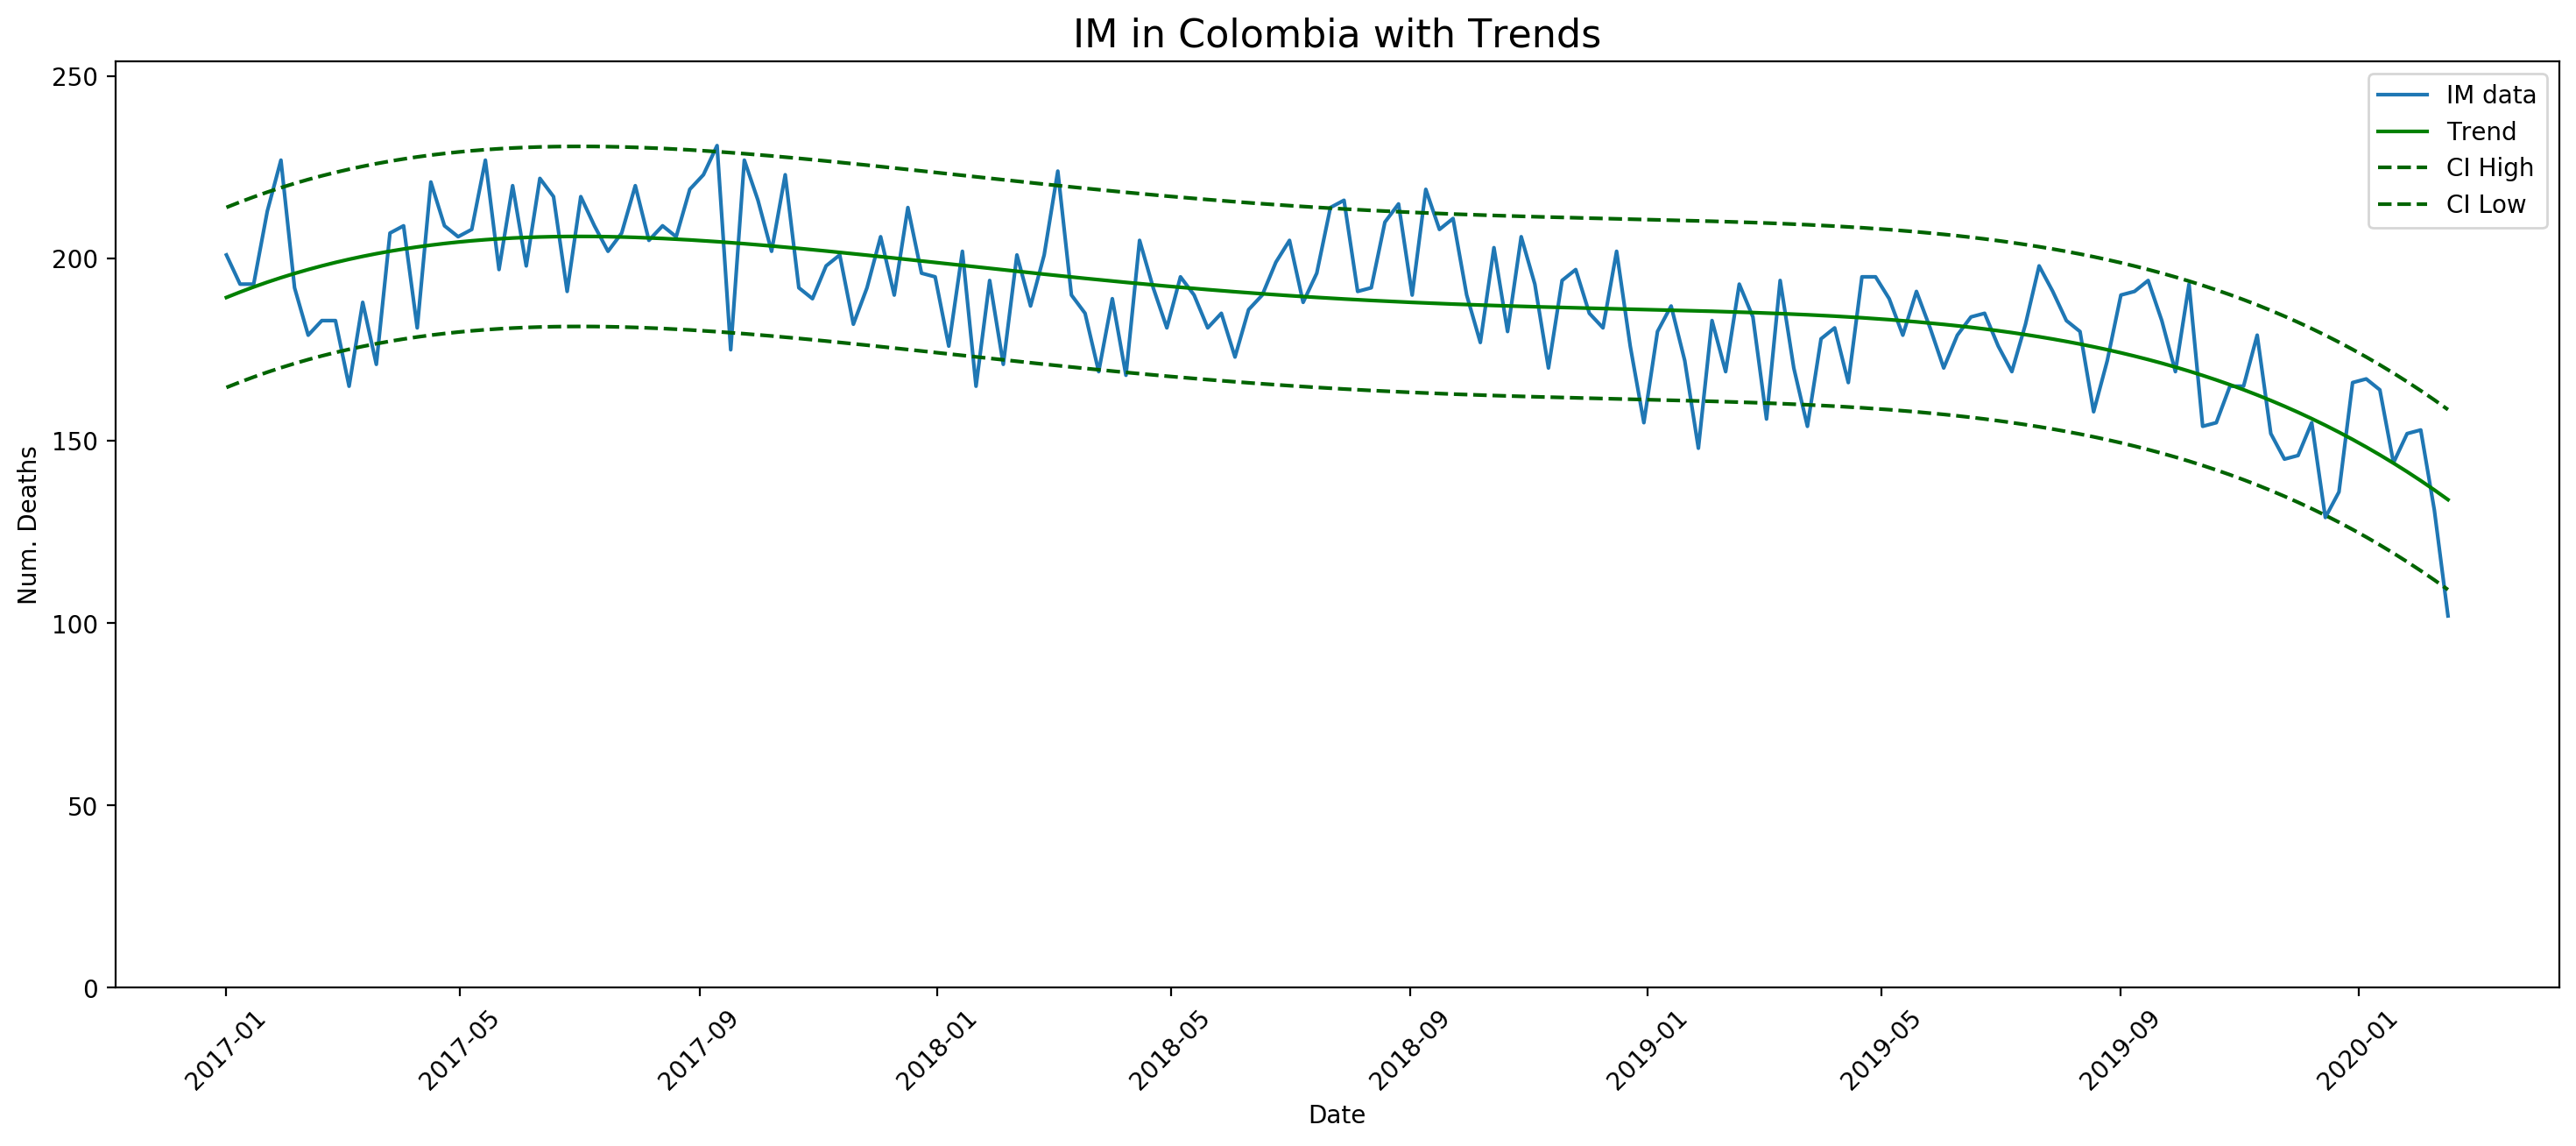

In [23]:
# Plot chart
plt.figure(figsize=(18, 7), dpi=200)
plt.plot(x_date, y_data, '-', label='IM data')
plt.plot(x_date, y_pred, '-', color='green', label='Trend')
plt.plot(x_date, y_pred + ci, '--', color='darkgreen', label='CI High')
plt.plot(x_date, y_pred - ci, '--', color='darkgreen', label='CI Low')
plt.ylim((0, max_y))
plt.title('IM in Colombia with Trends', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.xticks(fontsize=10, rotation=45)
plt.legend()
plt.show()

#### Result
- RMSE: 14.92
- MAPE: 6.529 %

## 3. Time Series Analysis

In [24]:
# Control param for SARIMA and Holt-Winters methods
perc_test = 0.10
data_freq = 52
forecast_weeks = 52 - 7
run_fit = False

In [25]:
# Cooking time-series data with frequency
series_data = rawdata['value']
series_data = series_data.asfreq(freq='W')
series_data

date
2017-01-01    201
2017-01-08    193
2017-01-15    193
2017-01-22    213
2017-01-29    227
             ... 
2020-01-19    144
2020-01-26    152
2020-02-02    153
2020-02-09    131
2020-02-16    102
Freq: W-SUN, Name: value, Length: 164, dtype: int64

### 3.1. Statistical tests for stationarity

In a stationary **time series**, statistical properties such as mean and variance are constant over time. In a non-stationary series, these properties are dependent on time.

Augmented Dickey-Fuller unit root test:
- Tests for trend non-stationarity.
- Null hypothesis ($H_0$) is time series is non-stationary.

In [26]:
adf_results = adfuller(series_data)
print('ADF Statistic:', adf_results[0])
print('p-value:', adf_results[1])

ADF Statistic: 0.5105115889556945
p-value: 0.9851891099953061


In [27]:
adf_results = adfuller(series_data.diff().dropna())
print('ADF Statistic:', adf_results[0])
print('p-value:', adf_results[1])

ADF Statistic: -7.51640982160704
p-value: 3.892727651105727e-11


#### Result
- Based on ADF test statistic and p-value the time series is non-stationary. We fail to reject the null hypothesis.
- However, the first difference in the time series itself is stationary.

### 3.2. Correlation and autocorrelation

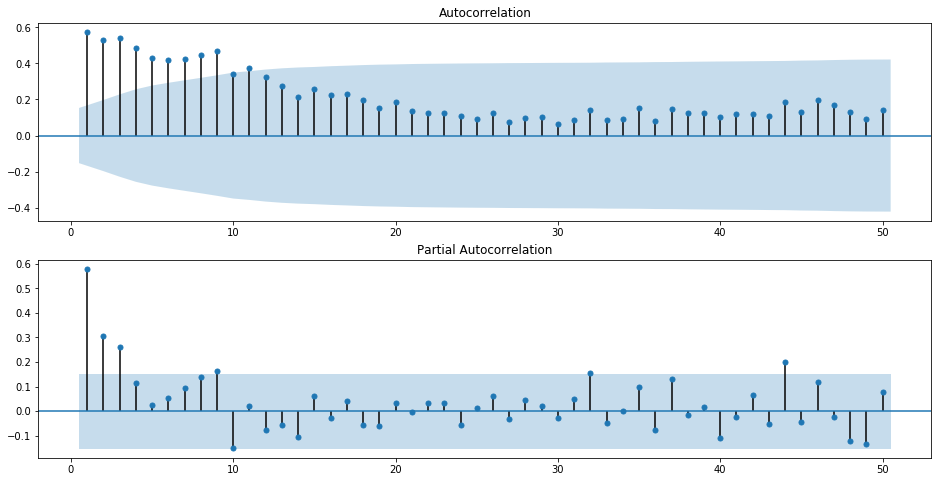

In [28]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))
plot_acf(series_data, lags=50, zero=False, ax=ax1)
plot_pacf(series_data, lags=50, zero=False, ax=ax2)
plt.show()

#### Result
We can use a $p = 3$.

### 3.3. Check seasonal decomposition

These components are defined as follows:
- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

#### 3.3.1. Additive decomposition
Additive series = Level + Trend + Seasonality + Noise

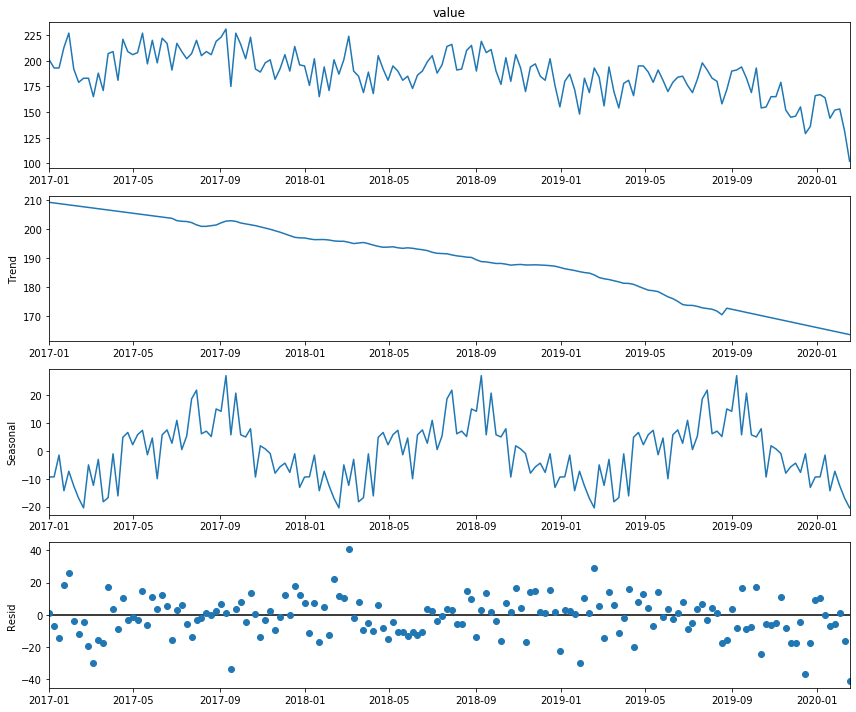

In [29]:
# Additive Decomposition
result_add = seasonal_decompose(series_data, model='additive', extrapolate_trend='freq')

# Show Additive Decompose
plt.rcParams.update({'figure.figsize': (12, 10)})
result_add.plot()
plt.show()

#### 3.3.2. Multiplicative decomposition
Multiplicative series = Level x Trend x Seasonality x Noise

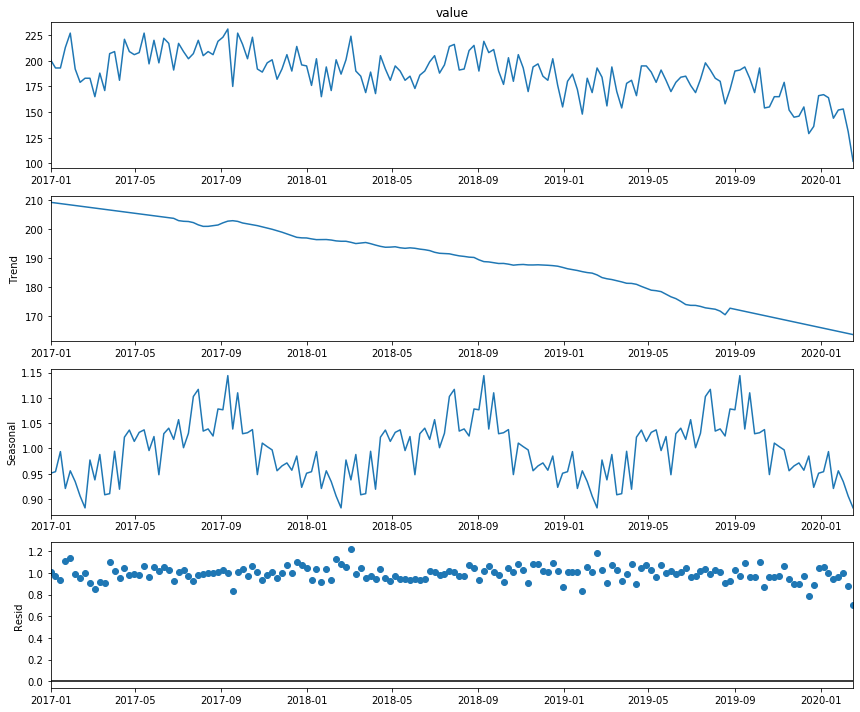

In [30]:
# Multiplicative Decomposition
result_add = seasonal_decompose(series_data, model='multiplicative', extrapolate_trend='freq')

# Show Additive Decompose
plt.rcParams.update({'figure.figsize': (12, 10)})
result_add.plot()
plt.show()

#### Result
Both the additive and multiplicative models have the following properties:
- Clear decreasing trend.
- It's a seasonal time series.
- The residuals oscillate around 0

## 4. Box-Jenkins Analysis

In time series analysis, the Box–Jenkins method, applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series.

### 4.1. Select best parameters for SARIMA model

AIC - Akaike information criterion
- Lower AIC indicates a better model
- AIC likes to choose simple models with lower order

BIC - Bayesian information criterion
- Very similar to AIC
- Lower BIC indicates a better model
- BIC likes to choose simple models with lower order

In [31]:
# Create a set of SARIMA configs to try
def arima_smoothing_configs():
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 3)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq  = [(x[0], x[1], x[2], data_freq) for x in list(itertools.product(p, d, q))]
    
    return pdq, seasonal_pdq

In [32]:
# Parameter Selection for the ARIMA Time Series Model
def arima_grid_search(pdq, seasonal_pdq):
    start_time = timeit.default_timer()
    
    # Specify to ignore warning messages
    filterwarnings("ignore")
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(series_data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()

                print('SARIMA: {} x {}, AIC:{}, BIC:{}'.format(param, param_seasonal, results.aic, results.bic))
            except:
                # Print AIC and BIC as None when fails
                print('SARIMA: {} x {}, AIC:{}, BIC:{}'.format(param, param_seasonal, None, None))
    
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    print('Elapsed time', elapsed, 's')

#### Run the grid search

In [33]:
# Run ARIMA fit
if run_fit:
    
    # Calculation params
    pdq, seasonal_pdq = arima_smoothing_configs()
    
    # Run grid search
    arima_grid_search(pdq, seasonal_pdq)
    print('Done SARIMA method')

### 4.2. Create SARIMA model

- Prob(Q) - p-value for null hypothesis that residuals are uncorrelated
- Prob(JB) - p-value for null hypothesis that residuals are normal

In [34]:
# Fitting a SARIMA Time Series model
filterwarnings("ignore")
model = sm.tsa.statespace.SARIMAX(series_data, order=(4, 2, 1), seasonal_order=(1, 0, 2, data_freq), 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()

In [35]:
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   value   No. Observations:                  164
Model:             SARIMAX(4, 2, 1)x(1, 0, [1, 2], 52)   Log Likelihood                -227.863
Date:                                 Fri, 17 Jul 2020   AIC                            473.727
Time:                                         15:08:57   BIC                            491.955
Sample:                                     01-01-2017   HQIC                           480.794
                                          - 02-16-2020                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2268      0.166     -1.365      0.172      -0.552       0

#### Plot diagnostics

If the model fits well the residuals will be white Gaussian noise.

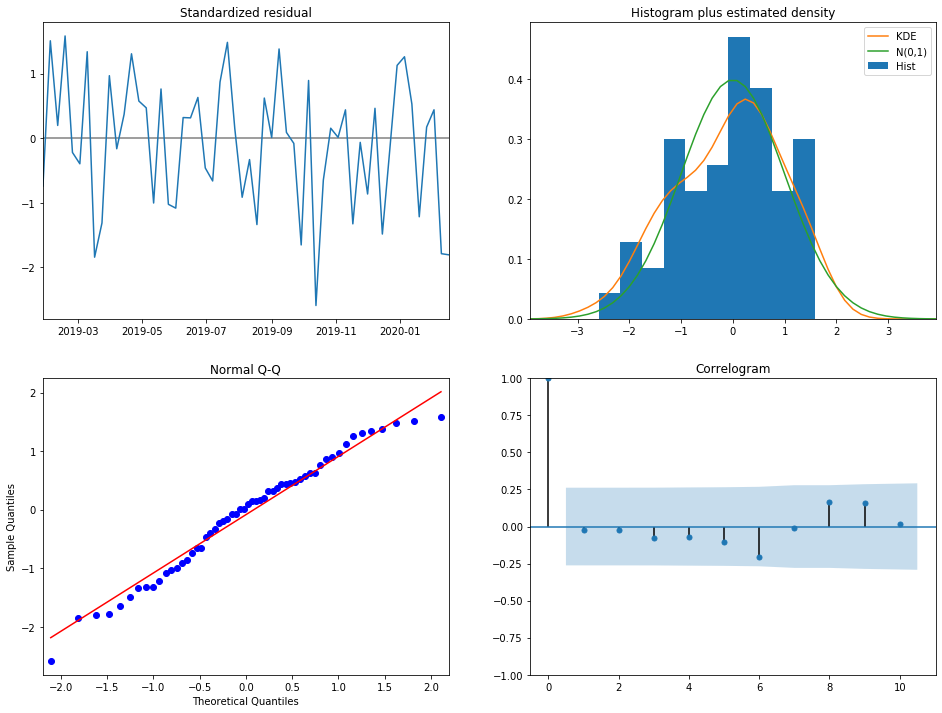

In [36]:
model.plot_diagnostics(figsize=(16, 12))
plt.show()

### 4.3. Validating SARIMA forecasts

In [37]:
# Start prediction from...
ix_test = ceil(len(series_data) * (1 - perc_test))
start_date = str(series_data.index[ix_test])
ix_test, start_date

(148, '2019-11-03 00:00:00')

#### 4.3.1. Validate prediction with dynamic False

In [38]:
# Validate prediction with dynamic False
pred = model.get_prediction(start=start_date, dynamic=False)
pred_ci = pred.conf_int(alpha=1-ci_alpha)

# Show predictions
y_forecasted = pd.Series(np.array([round(p) for p in pred.predicted_mean]), pred.predicted_mean.index)
y_forecasted

date
2019-11-03    165
2019-11-10    173
2019-11-17    171
2019-11-24    146
2019-12-01    158
2019-12-08    149
2019-12-15    150
2019-12-22    139
2019-12-29    150
2020-01-05    149
2020-01-12    157
2020-01-19    161
2020-01-26    150
2020-02-02    147
2020-02-09    156
2020-02-16    127
Freq: W-SUN, dtype: int32

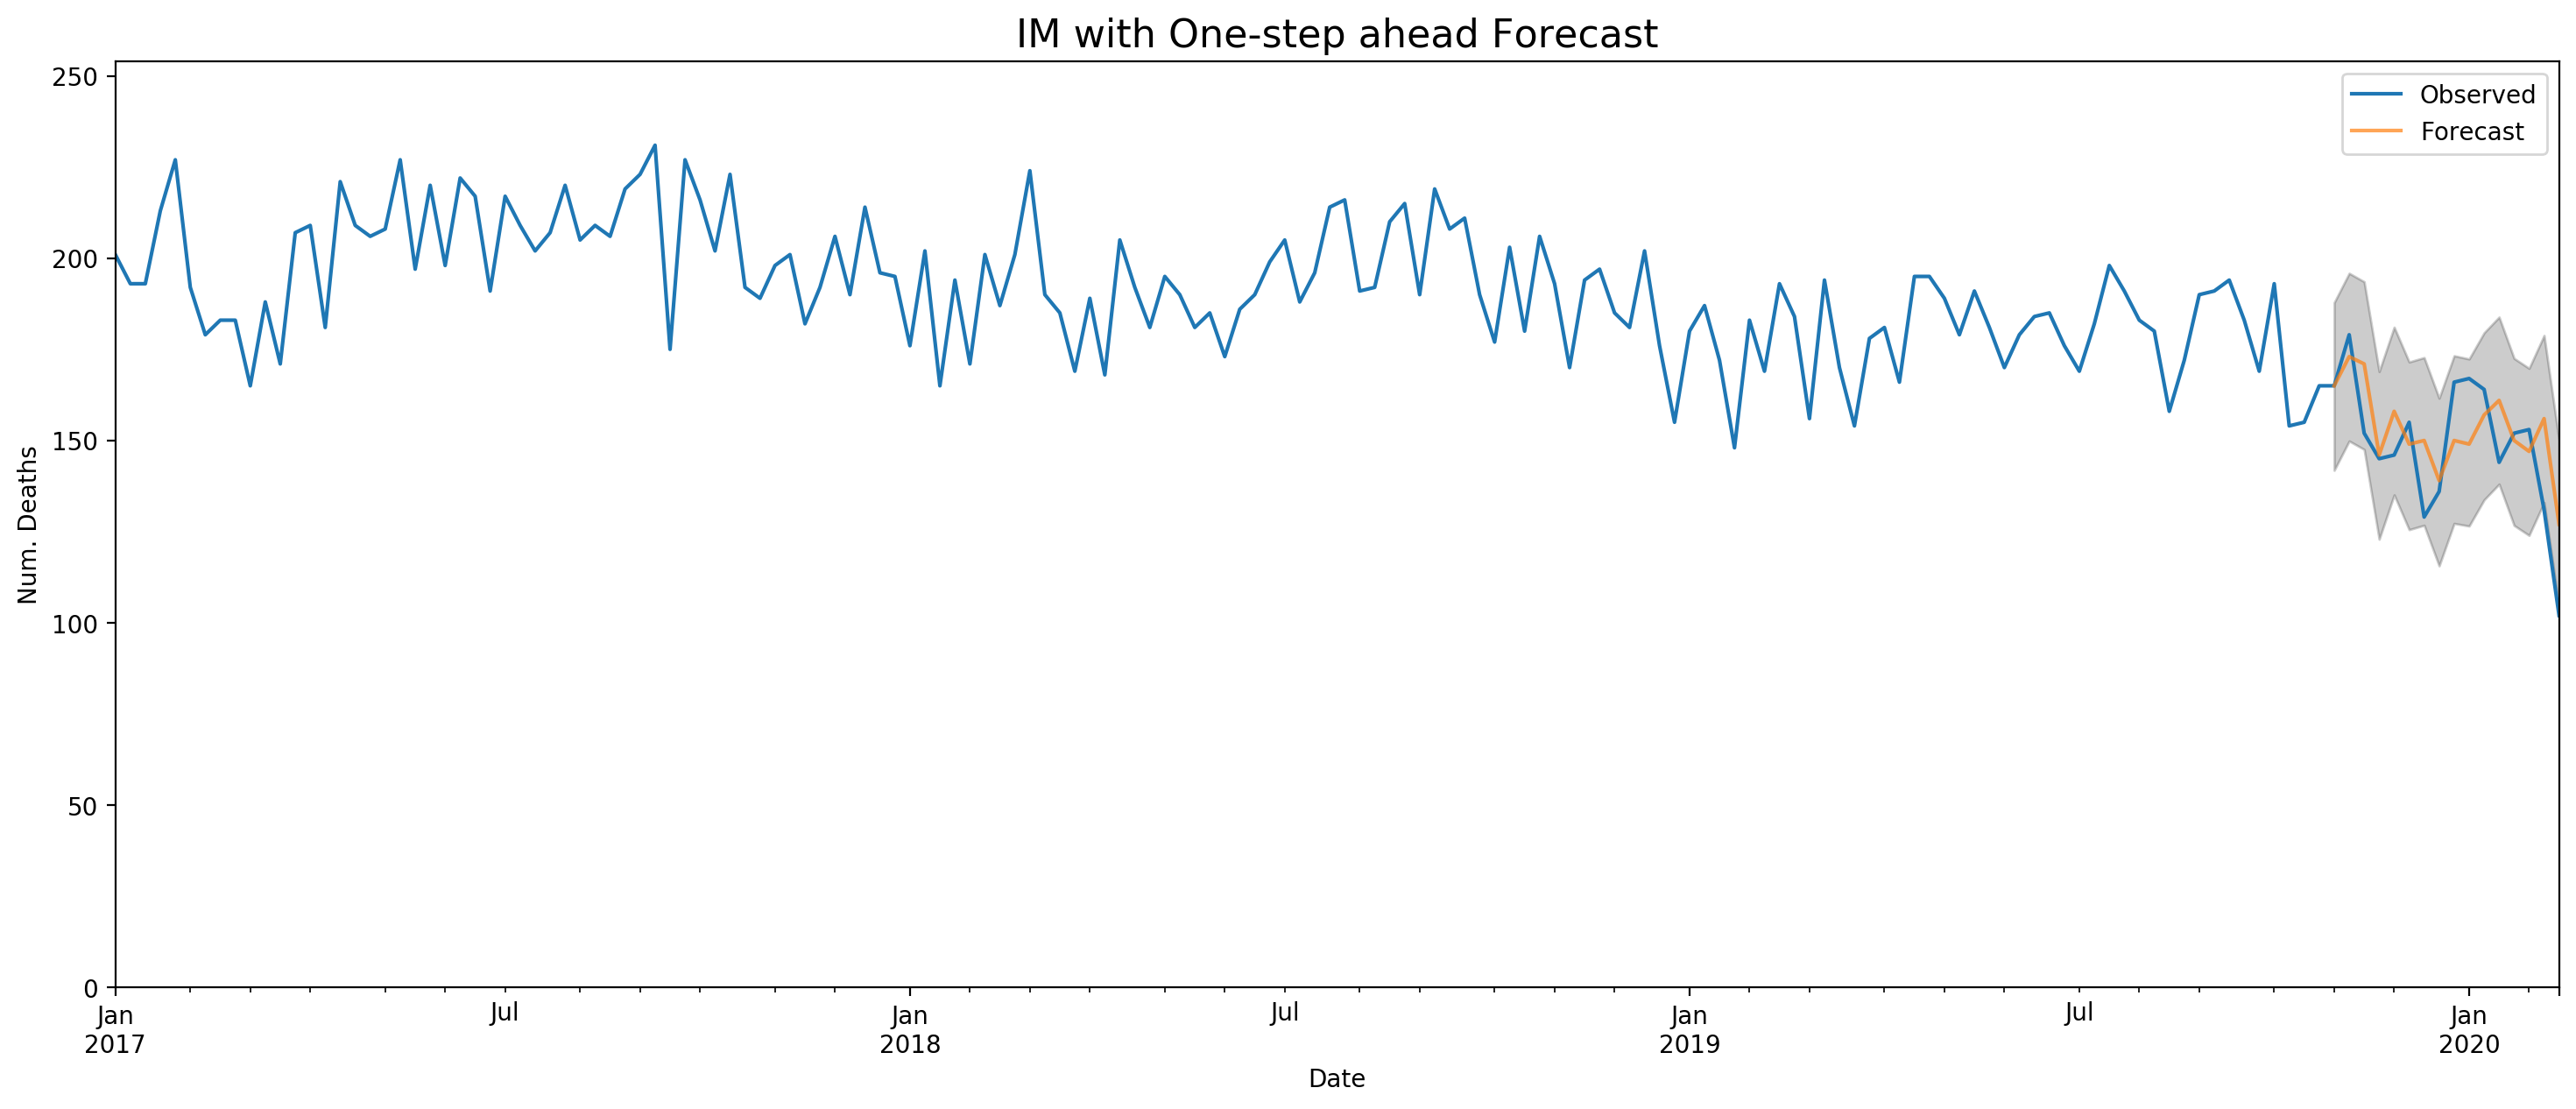

In [39]:
# Plot results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
y_forecasted.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.ylim((0, max_y))
plt.title('IM with One-step ahead Forecast', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.legend()
plt.show()

In [40]:
# Extract the predicted and true values of our time series
y_truth = series_data[start_date:]

# Compute the errors
rmse = calc_rmse(y_truth, y_forecasted)
mape = calc_mape(y_truth, y_forecasted)
print('The RMSE of our forecasts is: {}'.format(round(rmse, 3)))
print('The MAPE of our forecasts is: {} %'.format(round(mape, 3)))

The RMSE of our forecasts is: 14.221
The MAPE of our forecasts is: 8.277 %


#### 4.3.2. Validate prediction with dynamic True

In [41]:
# Predict
pred_dynamic = model.get_prediction(start=start_date, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int(alpha=1-ci_alpha)

# Show predictions
y_forecasted = pd.Series(np.array([round(p) for p in pred_dynamic.predicted_mean]), pred_dynamic.predicted_mean.index)
y_forecasted

date
2019-11-03    165
2019-11-10    173
2019-11-17    165
2019-11-24    158
2019-12-01    163
2019-12-08    167
2019-12-15    156
2019-12-22    167
2019-12-29    174
2020-01-05    163
2020-01-12    161
2020-01-19    164
2020-01-26    171
2020-02-02    160
2020-02-09    164
2020-02-16    156
Freq: W-SUN, dtype: int32

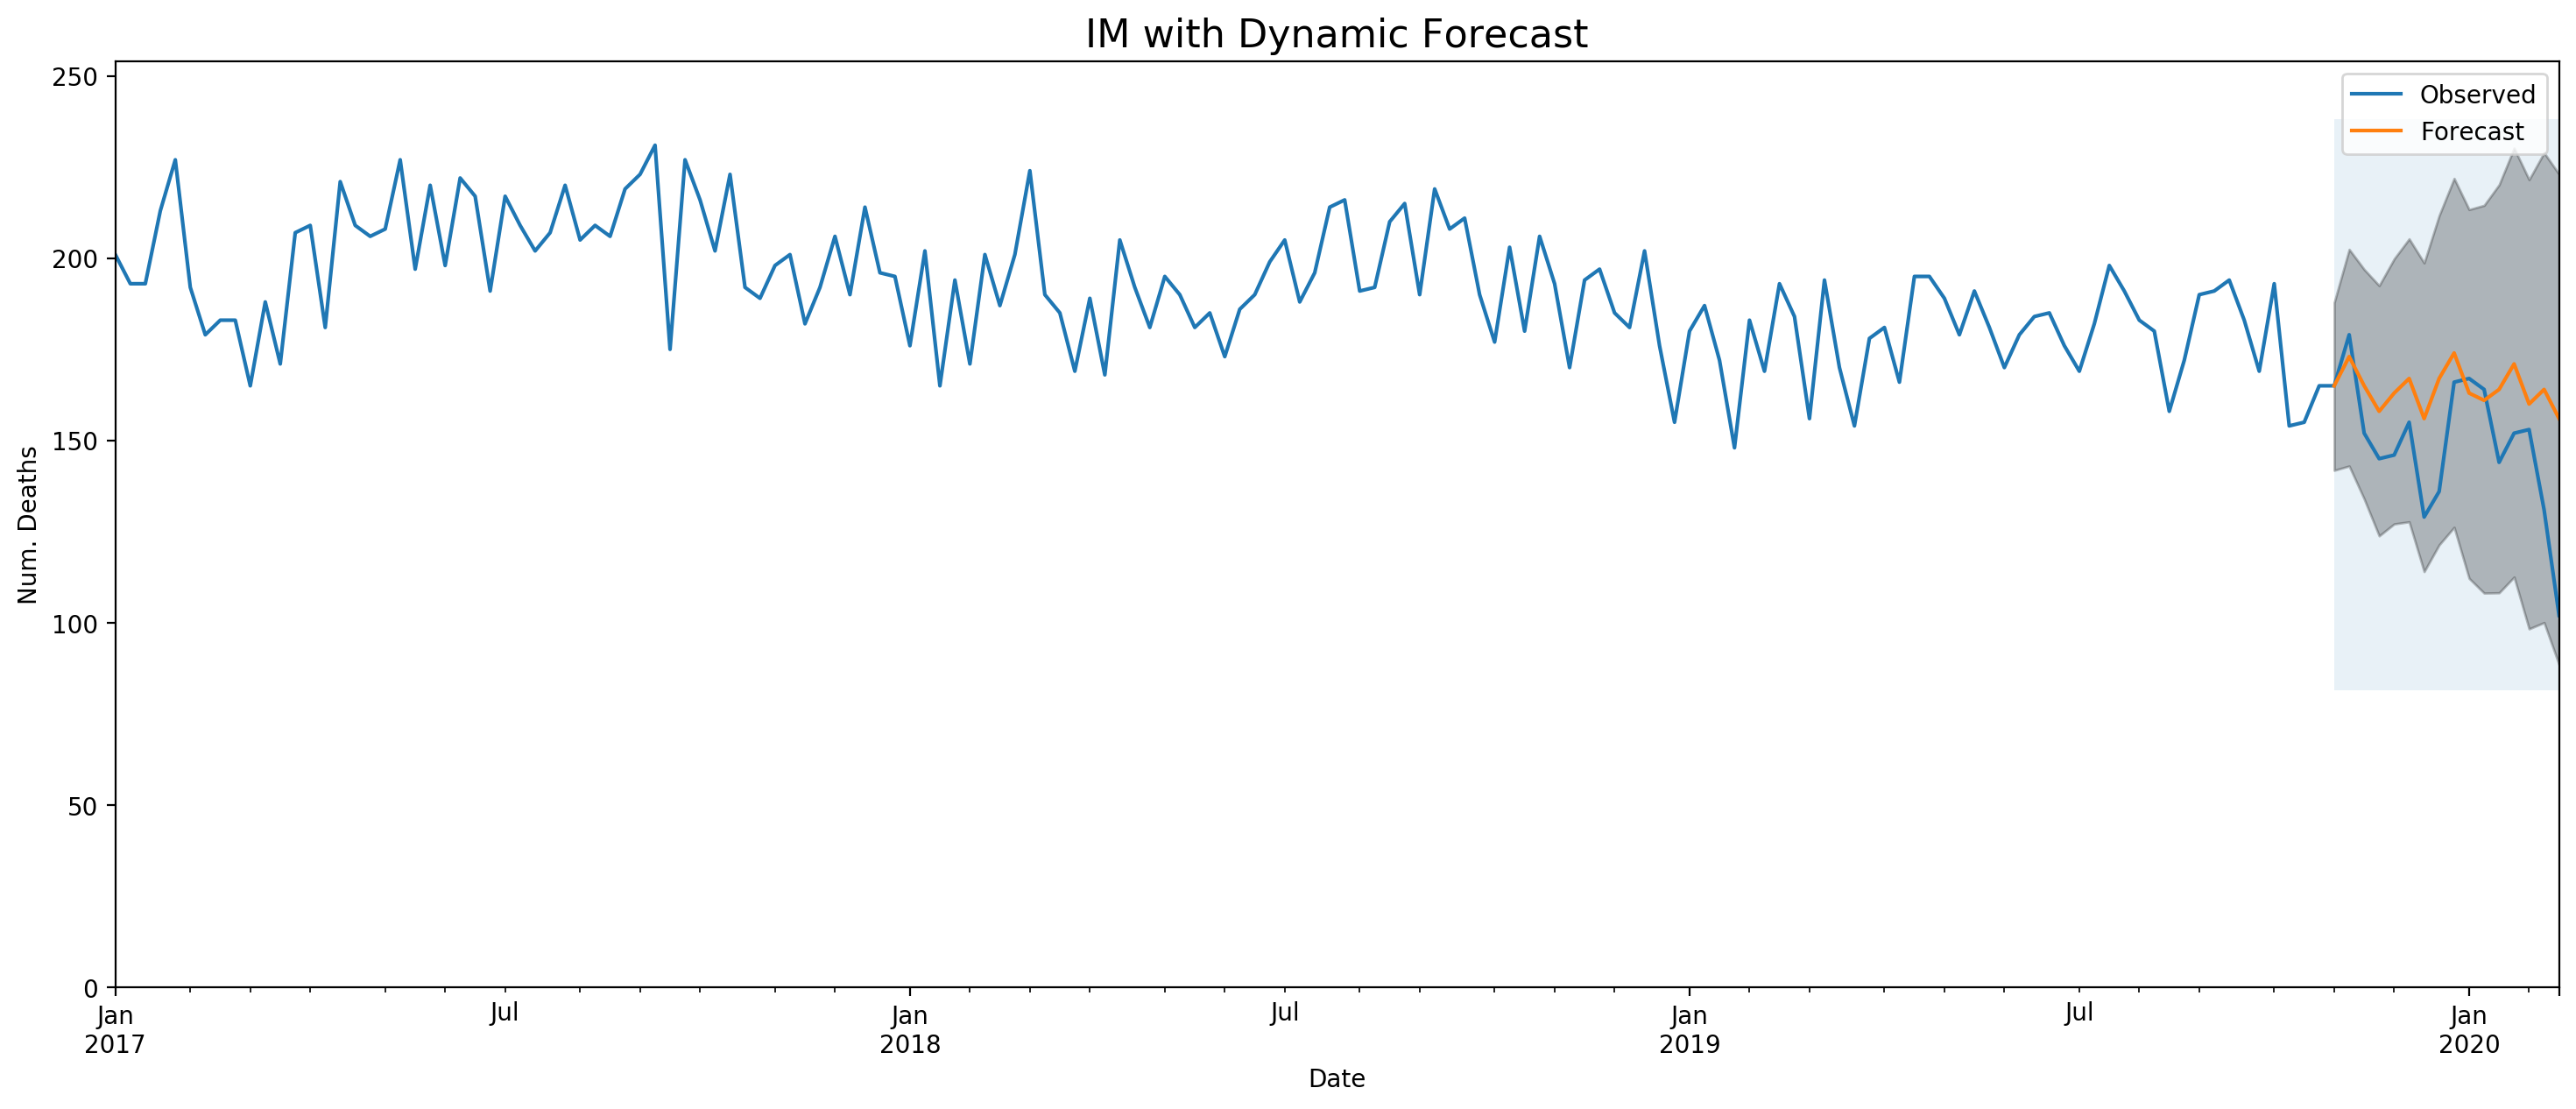

In [42]:
# Plot results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
y_forecasted.plot(label='Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pred_dynamic_ci.index[0], pred_dynamic_ci.index[-1], alpha=.1, zorder=-1)
plt.ylim((0, max_y))
plt.title('IM with Dynamic Forecast', fontsize=16)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.legend()
plt.show()

In [43]:
# Extract the predicted and true values of our time series
y_truth = series_data[start_date:]

# Compute the errors
rmse = calc_rmse(y_truth, y_forecasted)
mape = calc_mape(y_truth, y_forecasted)
print('The RMSE of our forecasts is: {}'.format(round(rmse, 3)))
print('The MAPE of our forecasts is: {} %'.format(round(mape, 3)))

The RMSE of our forecasts is: 21.507
The MAPE of our forecasts is: 12.633 %


### 4.4. Producing and visualizing forecasts

In [44]:
# Get forecast 52 steps ahead in future (1 year)
pred_uc = model.get_forecast(steps=forecast_weeks)
y_forecasted = pd.Series(np.array([max(round(p),0) for p in pred_uc.predicted_mean]), pred_uc.predicted_mean.index)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int(alpha=1-ci_alpha)

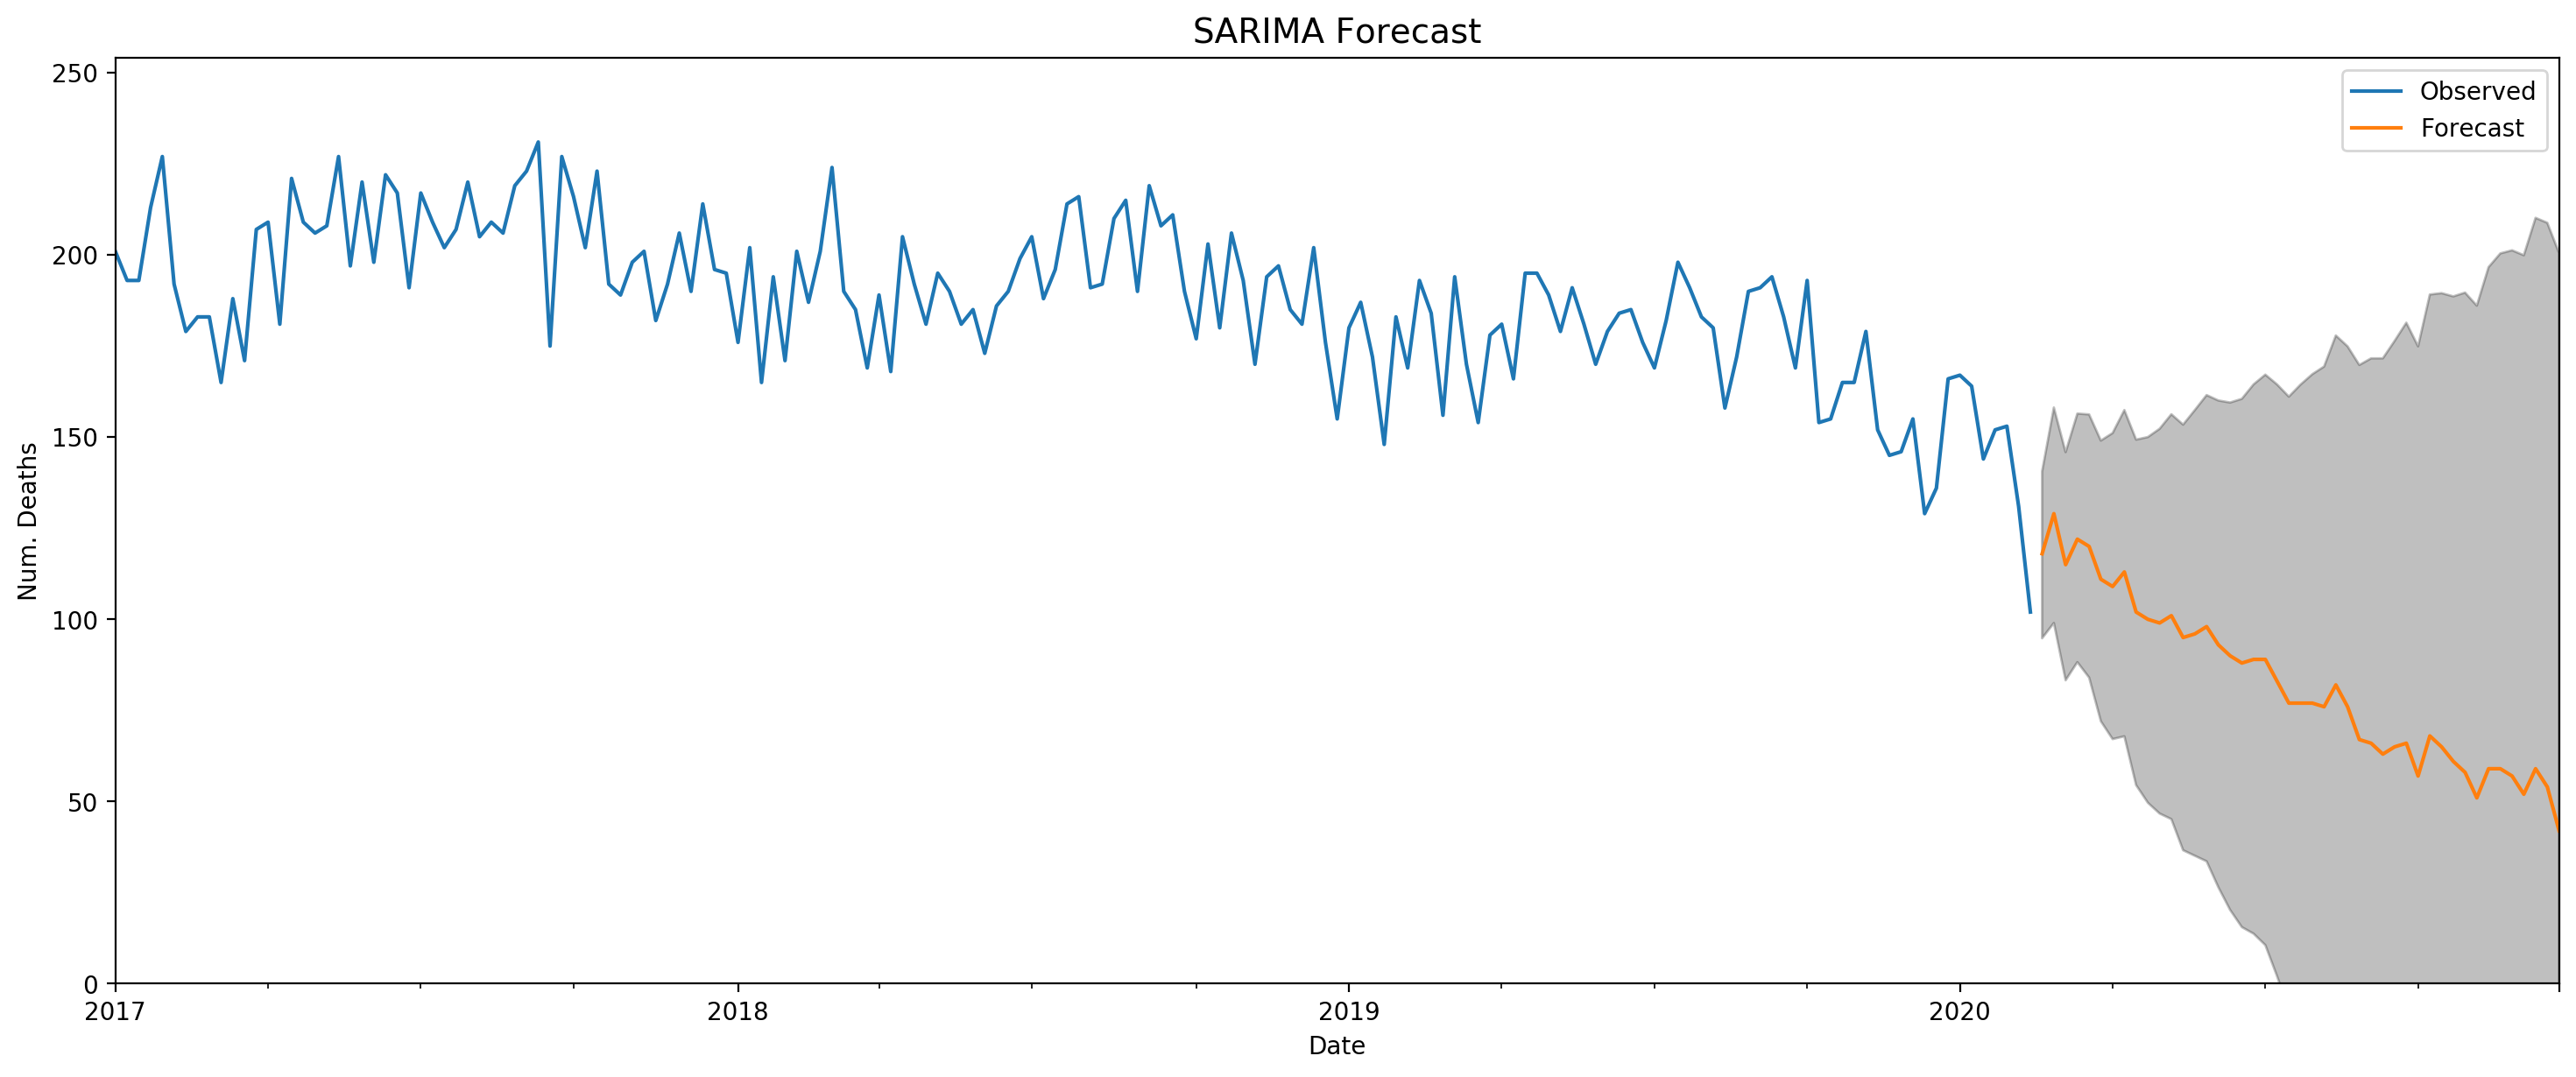

In [45]:
# Plot ARIMA results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
y_forecasted.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.ylim((0, max_y))
plt.title('SARIMA Forecast', fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.legend()
plt.show()

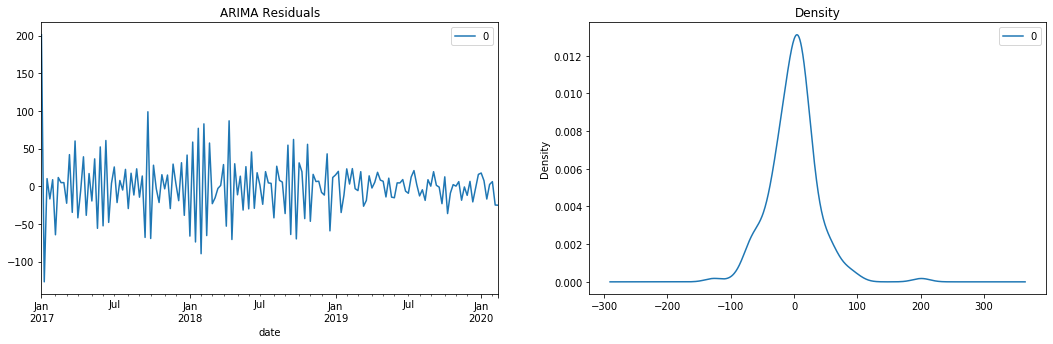

In [46]:
# Plot ARIMA residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
residuals.plot(title="ARIMA Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.legend()
plt.show()

#### Result
- RMSE: 13.987
- MAPE: 8.521 %
- AIC: 466.22
- BIC: 482.28
- Elapsed Time: 5.8 hr

## 5. Holt-Winters Analysis

**Exponential smoothing** is a time series forecasting method for univariate data that can be extended to support data with a systematic trend or seasonal component.

There are three types of exponential smoothing; they are:
- Single Exponential Smoothing, or SES, for univariate data without trend or seasonality.
- Double Exponential Smoothing for univariate data with support for trends.
- Triple Exponential Smoothing, or **Holt-Winters** Exponential Smoothing, with support for both trends and seasonality.

We will use the implementation of <a href="https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html" target="_blank">Holt-Winters Exponential Smoothing</a> provided by the statsmodels library.

### 5.1. Select best parameters for Holt-Winters model

This model has hyperparameters that control the nature of the exponential performed for the series, trend, and seasonality, specifically:
- **smoothing_level** (alpha): the smoothing coefficient for the level.
- **smoothing_slope** (beta): the smoothing coefficient for the trend.
- **smoothing_seasonal** (gamma): the smoothing coefficient for the seasonal component.
- **damping_slope** (phi): the coefficient for the damped trend.

There are other hyperparameters that the model will not automatically tune that you may want to specify; they are:
- **trend**: The type of trend component, as either “add” for additive or “mul” for multiplicative. Modeling the trend can be disabled by setting it to None.
- **damped**: Whether or not the trend component should be damped, either True or False.
- **seasonal**: The type of seasonal component, as either “add” for additive or “mul” for multiplicative. Modeling the seasonal component can be disabled by setting it to None.
- **seasonal_periods**: The number of time steps in a seasonal period, e.g. 12 for 12 months in a yearly seasonal structure.
- **use_boxcox**: Whether or not to perform a power transform of the series (True/False) or specify the lambda for the transform.

In [47]:
# Create a set of exponential smoothing configs to try
def exp_smoothing_configs(seasonal=[None]):
    
    # Define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    
    models = list(itertools.product(t_params, d_params, s_params, p_params, b_params, r_params))
    
    return models

In [48]:
# Split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [49]:
# One-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t, d, s, p, b, r = config
    
    # define model
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    
    # Fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    
    # Make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    
    return yhat[0]

# Walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    
    # Split dataset
    train, test = train_test_split(data, n_test)
    
    # Seed history with training dataset
    history = [x for x in train]
    
    # Step over each time-step in the test set
    for i in range(len(test)):
        
        # Fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        
        # Store forecast in list of predictions
        predictions.append(yhat)
        
        # Add actual observation to history for the next loop
        history.append(test[i])
    
    # Round predictions
    predictions = np.array([round(p) for p in predictions])
    
    # Estimate prediction error
    rmse = calc_rmse(test, predictions)
    mape = calc_mape(test, predictions)
    
    return rmse, mape

# Score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    rmse, mape = None, None
    
    # Convert config to a key
    key = str(cfg)
    
    # Show all warnings and fail on exception if debugging
    if debug:
        rmse, mape = walk_forward_validation(data, n_test, cfg)
    else:
        # One failure during model validation suggests an unstable config
        try:
            # Never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                rmse, mape = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
            
    # Check for an interesting result
    if rmse is not None or mape is not None:
        print(' > Model %s, RMSE %.3f, MAPE %.3f' % (key, rmse, mape))
    
    return (key, rmse, mape)

# Run grid search configs
def hw_grid_search(data, param_list, n_test, parallel=True):
    scores = None
    
    if parallel:
        # Execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in param_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in param_list]
        
    # Remove empty results
    scores = [r for r in scores if r[1] is not None or r[2] is not None]
    
    # Sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    
    return scores

#### Run the grid search

In [50]:
# Run Holt-Winters fit
if run_fit:
    start_time = timeit.default_timer()
    
    # Calculation params
    param_list = exp_smoothing_configs([0, 13, 52])
    n_test = int(len(series_data.values) * perc_test)
    parallel = False
    
    # Grid search
    scores = hw_grid_search(series_data.values, param_list, n_test, parallel)
    print('Done Holt-Winters method')
    
    # Elapsed time
    elapsed = timeit.default_timer() - start_time
    print('Elapsed time', elapsed, 's')
    
    # List top 10 configs
    for cfg, rmse, mape in scores[:10]:
        print(cfg, rmse, mape)

### 5.2. Create Holt-Winters model

In [51]:
# Fitting a Holt-Winters Time Series model
history = series_data.values
model = ExponentialSmoothing(history, trend='mul', damped=True, seasonal='add', seasonal_periods=13)
model = model.fit(optimized=True, use_boxcox=False, remove_bias=False)

In [52]:
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  164
Model:             ExponentialSmoothing   SSE                          35351.639
Optimized:                         True   AIC                            917.210
Trend:                   Multiplicative   BIC                            973.008
Seasonal:                      Additive   AICC                           923.084
Seasonal Periods:                    13   Date:                 Fri, 17 Jul 2020
Box-Cox:                          False   Time:                         15:09:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2509203                alpha                 True
smoothing_slope          

### 5.3. Producing and visualizing forecasts

In [53]:
# Get forecast 52 steps ahead in future (1 year)
pred_hw = model.forecast(steps=forecast_weeks)
pred_hw = np.array([round(p) for p in pred_hw])

# Get confidence intervals of forecasts
pred_df = pd.DataFrame(pred_hw, columns=['forecast'])
pred_df = pred_df.set_index(pred_uc.predicted_mean.index)
pred_df['ci_inf'] = pred_hw * (1-ci_alpha/2)
pred_df['ci_sup'] = pred_hw * (1+ci_alpha/2)
pred_df.head()

,forecast,ci_inf,ci_sup
2020-02-23,138.0,75.90,200.10
2020-03-01,132.0,72.60,191.40
2020-03-08,140.0,77.00,203.00
2020-03-15,133.0,73.15,192.85
2020-03-22,132.0,72.60,191.40


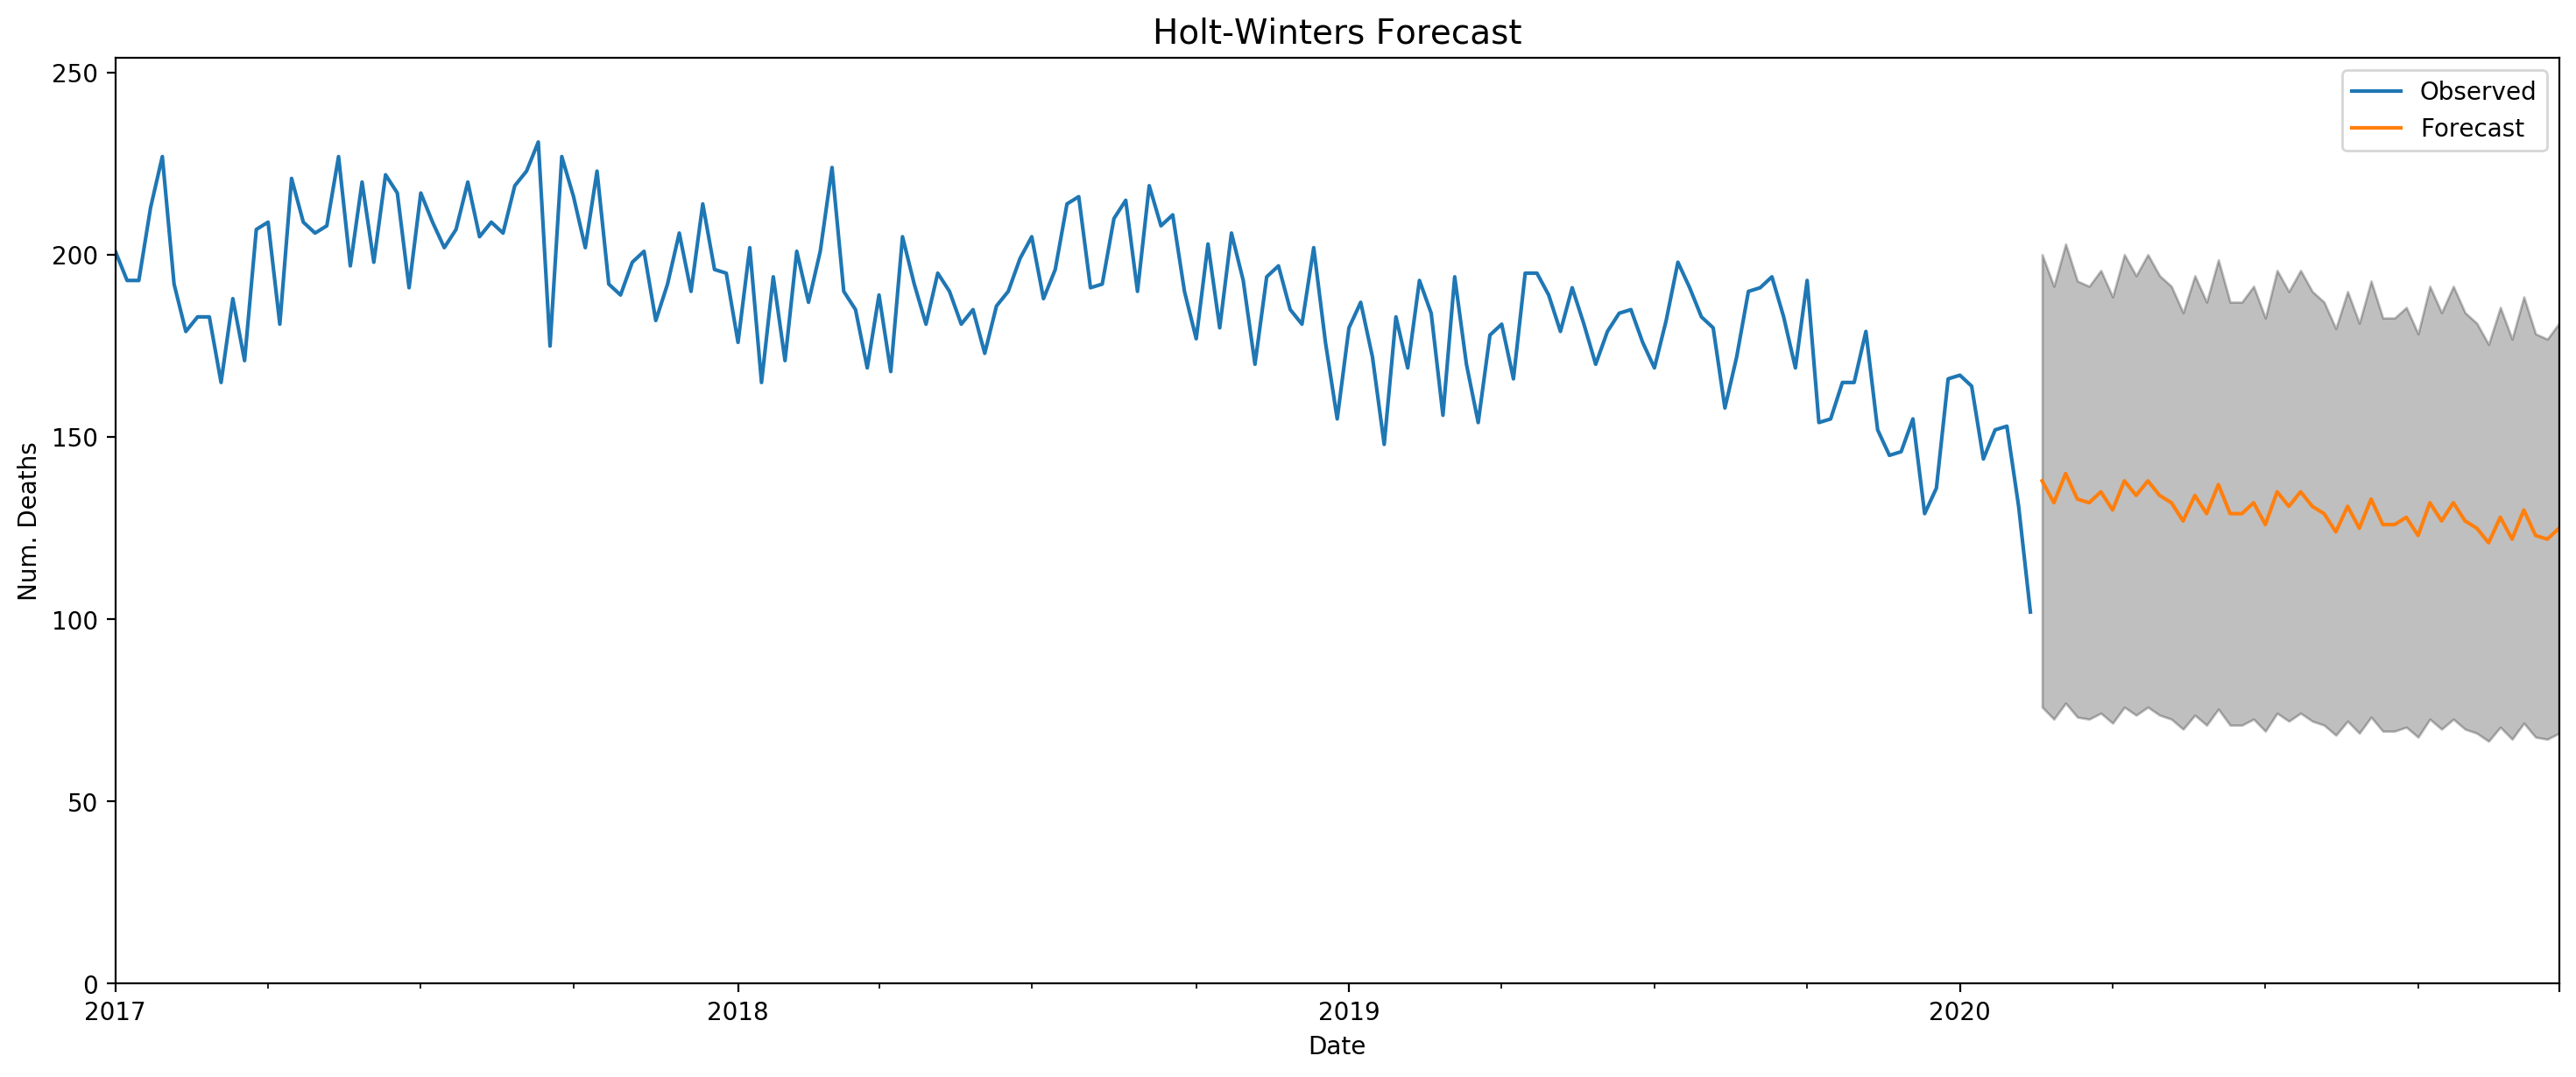

In [54]:
# Plot results
plt.figure(figsize=(18, 7), dpi=200)
ax = series_data.plot(label='Observed')
pred_df.forecast.plot(ax=ax, label='Forecast')
ax.fill_between(pred_df.index, pred_df.ci_inf, pred_df.ci_sup, color='k', alpha=.25)
plt.ylim((0, max_y))
plt.title('Holt-Winters Forecast', fontsize = 14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Num. Deaths', fontsize=10)
plt.legend()
plt.show()

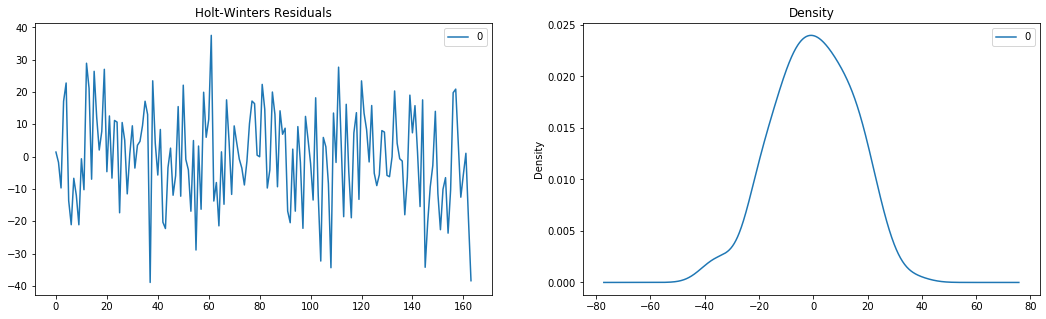

In [55]:
# Plot Holt-Winters residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
residuals.plot(title="Holt-Winters Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.legend()
plt.show()

#### Result
- RMSE: 16.998
- MAPE: 9.782 %
- AIC: 917.210
- BIC: 973.008
- Elapsed Time: 23m

## 6. Compare Models

In [56]:
# Set normalized data
df = pd.DataFrame({
    'group': ['ARIMA','HW'],
    'rmse': [0.699, 0.8499],
    'mape': [0.568, 0.978],
    'aic': [0.466, 0.917],
    'bic': [0.482, 0.973],
    'time': [0.962, 0.064]
})

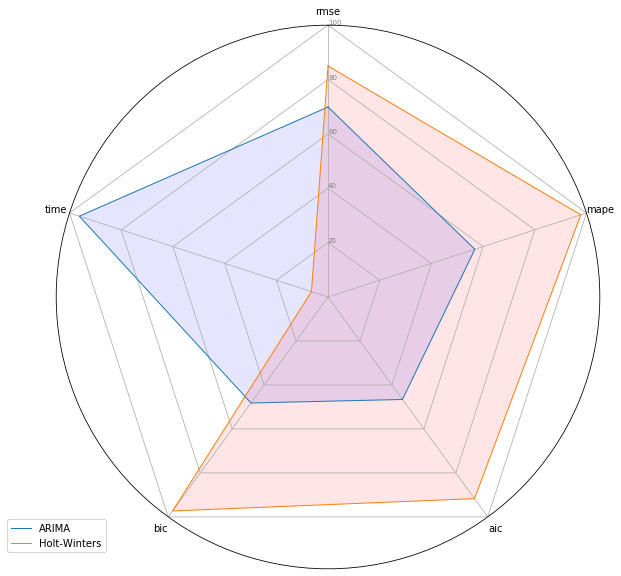

In [57]:
# PART 1: Create background
# Number of variable
categories = list(df)[1:]
num_vars = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Pentagon instead of circle
gridlines = ax.yaxis.get_gridlines()
for gl in gridlines:
    gl.get_path()._interpolation_steps = num_vars

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1], ["20","40","60", "80", "100"], color="grey", size=7)
plt.ylim(0, 1)

# PART 2: Add plots 
# Ind1
values = df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="ARIMA")
ax.fill(angles, values, 'b', alpha=0.1)

# Ind2
values = df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="Holt-Winters")
ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

---
End of analysis